## Classifying MNIST with Le-Net 

In [1]:
import numpy as np
from mygrad import Tensor

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

import matplotlib.pyplot as plt

%matplotlib notebook

### MNIST Data Loading and preprocessing

In [2]:
from datasets import load_mnist, download_mnist

`datasets module: datasets will be loaded from '/Users/DanBi/datasets'


In [3]:
download_mnist()# downloading the dataset

File already exists:
	/Users/DanBi/datasets/mnist.npz


In [4]:
#loading the data set
train_data, train_truth, test_data, test_truth = load_mnist()

mnist loaded


In [19]:
#scale down the training and testing data between 0 and 1 where 0 is white and 1 is black
train_data = (train_data/np.amax(train_data)).astype(np.float32)
test_data = (test_data/np.amax(test_data)).astype(np.float32)

# checking if data type is float
test_data.dtype == np.float32

True

A function that measuers accuracy

In [7]:
from collections import Counter

In [22]:
def measure_acc(predictions, truth):
    '''
    Arguments: 
    predictions, truth - the predicted labels and the actual labels from the training data set. 
    
    Functionality:
    calculates the accuracy of the predictions based on existing labels
    '''
    if isinstance(predictions, Tensor):
        predictions = predictions.data
    pred = np.argmax(predictions, axis = 1)
    accuracy = (pred == truth)
    return np.mean(accuracy)

### Creating Layers of our ConvNet

Constructing the main architecture for our convolutional neural network. 


In [36]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout
from mynn.activations.relu import relu
from mynn.initializers.glorot_uniform import glorot_uniform
from mygrad.nnet.layers import max_pool
from mynn.losses.cross_entropy import softmax_cross_entropy

In [23]:
class Model:
    ''' A simple convolutional neural network. '''
    def __init__(self):
        
        #this gain is a parameter for the weight initializiation function glorot_uniform
        init_kwargs = {'gain': np.sqrt(2)}
        
        #Using a dropout probability of 0.5 so that values are randomly set to 0 in our data
        self.dropout_prob = 0.5

        
        self.dense1 = dense(180, 200, weight_initializer = glorot_uniform, weight_kwargs = init_kwargs)
    
        self.dense2 = dense(200, 10, weight_initializer = glorot_uniform, weight_kwargs = init_kwargs)
        
        self.conv1 = conv(1, 20, (5, 5), stride = 1, padding = 0, weight_initializer = glorot_uniform, weight_kwargs = init_kwargs)
    
        self.conv2 = conv(20, 20, (2, 2), stride = 2, padding = 0, weight_initializer = glorot_uniform, weight_kwargs = init_kwargs)
        
        self.dropout = dropout(self.dropout_prob)
    
    
    def __call__(self, x):
        ''' Defines a forward pass of the model.
        
        Parameters
        ----------
        x : numpy.ndarray, shape=(N, 1, 28, 28)
            The input data, where N is the number of images.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 10)
            The class scores for each of the N images.
        
        Pseudo-code
        -----------
        >>> compute the first convolutional layer by doing x.conv1
        >>> Perform ReLU by using relu(x)
        >>> Perform dropout by using x.dropout()
        >>> Use max_pool(x, size_pool, stride) to perform the pooling layer
        >>> repeat once 
        >>> perform two dense layers with ReLU dropout in between
        '''
        
        #first conv layer
        x = self.conv1(x)
        x = relu(x)
        x = self.dropout(x)
        x = max_pool(x, (2, 2), 2)
        
        #second conv layer
        x = self.conv2(x)
        x = relu(x)
        x = self.dropout(x)
        x = max_pool(x, (2, 2), 2)
        
        #performing the two dense layers
        x = x.reshape(x.shape[0], -1)
        
        x = self.dense1(x)
        x = relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        
        return x
    
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        #creates a list of every parameter contained in the 4 layers in the model.
        return self.conv1.parameters + self.conv2.parameters + self.dense1.parameters + self.dense2.parameters
    
    
    

In [174]:
model = Model()

In [24]:
from mynn.optimizers.sgd import SGD
sgd = SGD(model.parameters)

### Training our ConvNet

<IPython.core.display.Javascript object>


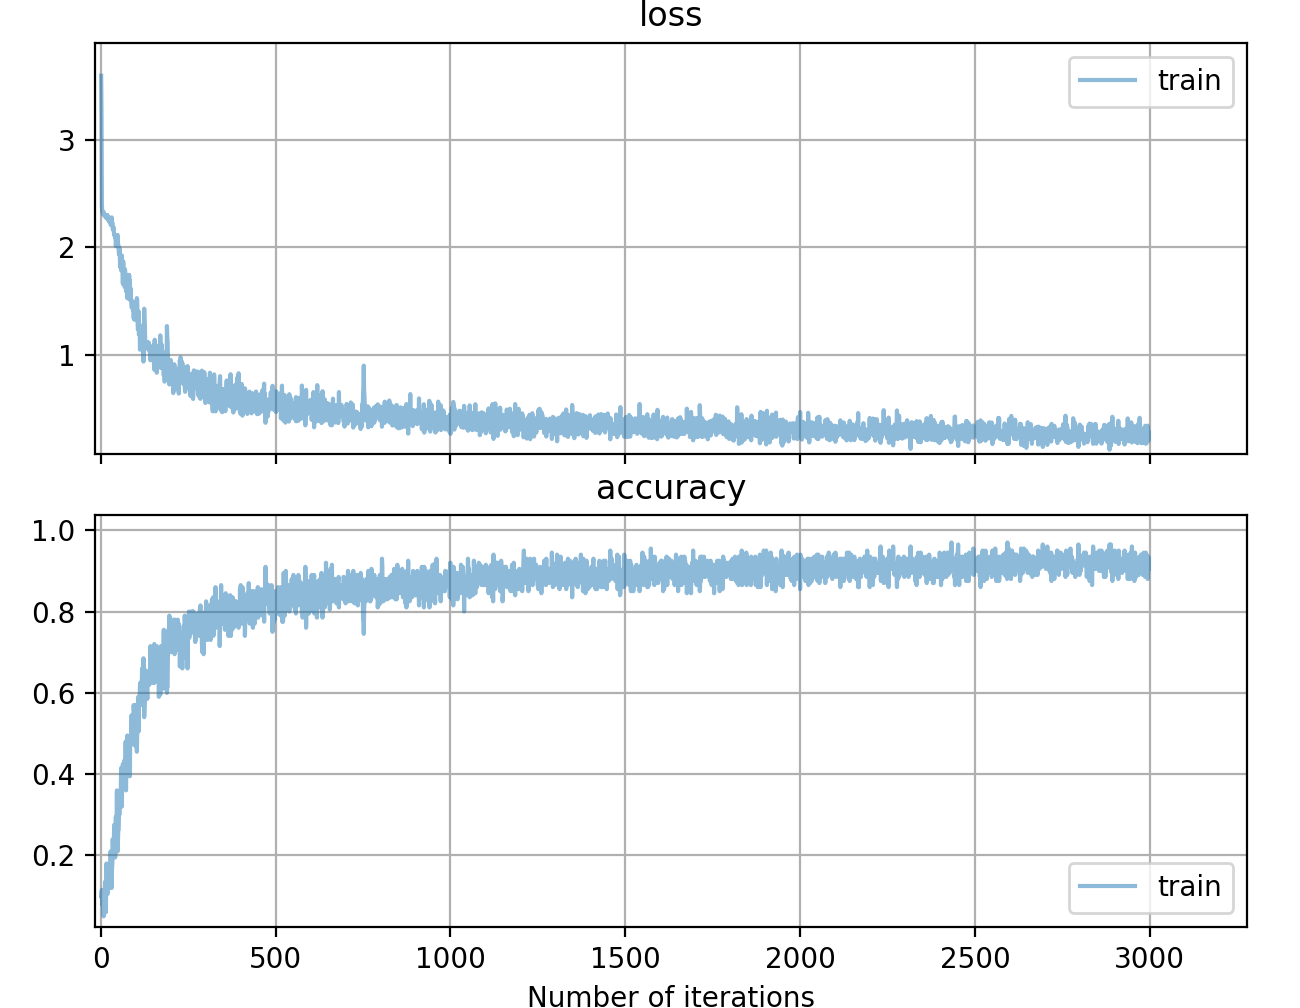

In [176]:
%matplotlib notebook
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh = 2.5)

In [177]:
batch_size = 200

lr = 0.1

for epoch_cnt in range(10):
    idxs = np.arange(len(train_data))
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, np.size(train_data, axis = 0)//batch_size):
        
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_data[batch_indices]  # random batch of our training data
        batch_truth = train_truth[batch_indices]
        
        prediction = model(batch) #computing the forward pass
        
        loss = softmax_cross_entropy(prediction, batch_truth) #calculating the loss
        
        acc = measure_acc(prediction, batch_truth) #calculating the accuracy
        
        loss.backward() #back propagation
        
        sgd.step() #schotastic gradient descent
        

        loss.null_gradients() #nulling the gradients
        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc},
                               batch_size=batch_size)

Saving the parameters

In [191]:
p = []
for i in model.parameters:
    p.append(i.data)
np.save("./params", p)